Create a class Greeks to display all greeks of call/put european option under Black scholes for delta, gamma, vega, rho, div, repo, theta, vanna, vomma, etc. Display each of them with a change of spot, time, vol, etc. + use a library that allows me to play with a cursor for the deformation of the parameters spot; for instance for the delta I want the delta in fonction of the spot and I want to be able to play with widget that allows me to reduice or increase the time to maturity. By changing the time i want all greeks to be affected simultaeousnly. the code will be used in a jupyter

In [ ]:
import QuantLib as ql
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider

class Greeks:
    def __init__(self, option_type, spot, strike, volatility, risk_free_rate, dividend_yield, time_to_maturity):
        self.option_type = option_type
        self.spot = spot
        self.strike = strike
        self.volatility = volatility
        self.risk_free_rate = risk_free_rate
        self.dividend_yield = dividend_yield
        self.time_to_maturity = time_to_maturity

        # Set up the QuantLib environment
        self.calendar = ql.TARGET()
        self.day_count = ql.Actual365Fixed()
        self.settlement_date = ql.Date.todaysDate()
        ql.Settings.instance().evaluationDate = self.settlement_date

        # Create the option
        self.maturity_date = self.settlement_date + ql.Period(int(self.time_to_maturity * 365), ql.Days)
        self.payoff = ql.PlainVanillaPayoff(ql.Option.Call if self.option_type == 'call' else ql.Option.Put, self.strike)
        self.exercise = ql.EuropeanExercise(self.maturity_date)
        self.european_option = ql.VanillaOption(self.payoff, self.exercise)

        # Set up the Black-Scholes process
        self.spot_handle = ql.QuoteHandle(ql.SimpleQuote(self.spot))
        self.rate_handle = ql.YieldTermStructureHandle(ql.FlatForward(self.settlement_date, ql.QuoteHandle(ql.SimpleQuote(self.risk_free_rate)), self.day_count))
        self.dividend_handle = ql.YieldTermStructureHandle(ql.FlatForward(self.settlement_date, ql.QuoteHandle(ql.SimpleQuote(self.dividend_yield)), self.day_count))
        self.volatility_handle = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(self.settlement_date, self.calendar, ql.QuoteHandle(ql.SimpleQuote(self.volatility)), self.day_count))
        self.bsm_process = ql.BlackScholesMertonProcess(self.spot_handle, self.dividend_handle, self.rate_handle, self.volatility_handle)

        # Pricing engine
        self.european_option.setPricingEngine(ql.AnalyticEuropeanEngine(self.bsm_process))

    def calculate_greeks(self):
        delta = self.european_option.delta()
        gamma = self.european_option.gamma()
        vega = self.european_option.vega()
        rho = self.european_option.rho()
        theta = self.european_option.theta()
        return delta, gamma, vega, rho, theta

    def plot_greeks(self, greek_type):
        spot_range = np.linspace(0.5 * self.spot, 1.5 * self.spot, 100)
        greek_values = []

        for spot in spot_range:
            self.spot_handle.linkTo(ql.SimpleQuote(spot))
            greeks = self.calculate_greeks()
            if greek_type == 'delta':
                greek_values.append(greeks[0])
            elif greek_type == 'gamma':
                greek_values.append(greeks[1])
            elif greek_type == 'vega':
                greek_values.append(greeks[2])
            elif greek_type == 'rho':
                greek_values.append(greeks[3])
            elif greek_type == 'theta':
                greek_values.append(greeks[4])

        plt.figure(figsize=(10, 6))
        plt.plot(spot_range, greek_values, label=greek_type)
        plt.xlabel('Spot Price')
        plt.ylabel(greek_type.capitalize())
        plt.title(f'{greek_type.capitalize()} vs Spot Price')
        plt.legend()
        plt.grid(True)
        plt.show()

# Interactive widgets
def interactive_greeks(spot, strike, volatility, risk_free_rate, dividend_yield, time_to_maturity, option_type, greek_type):
    greeks = Greeks(option_type, spot, strike, volatility, risk_free_rate, dividend_yield, time_to_maturity)
    greeks.plot_greeks(greek_type)

interact(interactive_greeks,
         spot=FloatSlider(min=50, max=150, step=1, value=100, description='Spot Price'),
         strike=FloatSlider(min=50, max=150, step=1, value=100, description='Strike Price'),
         volatility=FloatSlider(min=0.01, max=1.0, step=0.01, value=0.2, description='Volatility'),
         risk_free_rate=FloatSlider(min=0.0, max=0.1, step=0.01, value=0.05, description='Risk-Free Rate'),
         dividend_yield=FloatSlider(min=0.0, max=0.1, step=0.01, value=0.02, description='Dividend Yield'),
         time_to_maturity=FloatSlider(min=0.1, max=2.0, step=0.1, value=1.0, description='Time to Maturity (years)'),
         option_type=['call', 'put'],
         greek_type=['delta', 'gamma', 'vega', 'rho', 'theta'])


In [1]:
import numpy as np
import scipy.stats as si

class BlackScholesGreeks:
    def __init__(self, S, K, T, r, sigma, q=0, c=0, option_type="call"):
        """
        Black-Scholes model extended with repo rate and dividend yield.

        :param S: Spot price of the underlying asset
        :param K: Strike price of the option
        :param T: Time to maturity (in years)
        :param r: Risk-free rate
        :param sigma: Volatility
        :param q: Dividend yield
        :param c: Repo rate (cost of carry)
        :param option_type: "call" or "put"
        """
        self.S, self.K, self.T = S, K, T
        self.r, self.sigma, self.q, self.c = r, sigma, q, c
        self.option_type = option_type.lower()
    
    def d1(self):
        return (np.log(self.S / self.K) + (self.r - self.q + self.c + 0.5 * self.sigma**2) * self.T) / (self.sigma * np.sqrt(self.T))

    def d2(self):
        return self.d1() - self.sigma * np.sqrt(self.T)

    def price(self):
        """Black-Scholes price with dividend yield and repo rate."""
        d1, d2 = self.d1(), self.d2()
        if self.option_type == "call":
            return self.S * np.exp(-self.q * self.T) * si.norm.cdf(d1) - self.K * np.exp(-self.r * self.T) * si.norm.cdf(d2)
        else:
            return self.K * np.exp(-self.r * self.T) * si.norm.cdf(-d2) - self.S * np.exp(-self.q * self.T) * si.norm.cdf(-d1)

    # ---------------- Analytical Greeks ---------------- #
    
    def delta(self):
        d1 = self.d1()
        factor = np.exp(-self.q * self.T)
        return factor * si.norm.cdf(d1) if self.option_type == "call" else factor * (si.norm.cdf(d1) - 1)

    def gamma(self):
        d1 = self.d1()
        return np.exp(-self.q * self.T) * si.norm.pdf(d1) / (self.S * self.sigma * np.sqrt(self.T))

    def vega(self):
        d1 = self.d1()
        return self.S * np.exp(-self.q * self.T) * np.sqrt(self.T) * si.norm.pdf(d1)

    def rho(self):
        d2 = self.d2()
        if self.option_type == "call":
            return self.K * self.T * np.exp(-self.r * self.T) * si.norm.cdf(d2)
        else:
            return -self.K * self.T * np.exp(-self.r * self.T) * si.norm.cdf(-d2)

    def theta(self):
        d1, d2 = self.d1(), self.d2()
        term1 = - (self.S * np.exp(-self.q * self.T) * si.norm.pdf(d1) * self.sigma) / (2 * np.sqrt(self.T))
        term2 = self.q * self.S * np.exp(-self.q * self.T) * si.norm.cdf(d1)
        term3 = self.r * self.K * np.exp(-self.r * self.T) * si.norm.cdf(d2)

        if self.option_type == "call":
            return term1 - term2 - term3
        else:
            return term1 + term2 + self.r * self.K * np.exp(-self.r * self.T) * si.norm.cdf(-d2)

    # ---------------- Cross Greeks ---------------- #
    
    def vanna(self):
        d1 = self.d1()
        return np.exp(-self.q * self.T) * si.norm.pdf(d1) * np.sqrt(self.T) * (1 - d1 / self.sigma)

    def vomma(self):
        d1, d2 = self.d1(), self.d2()
        return self.vega() * d1 * d2 / self.sigma

    def charm(self):
        d1, d2 = self.d1(), self.d2()
        return -np.exp(-self.q * self.T) * si.norm.pdf(d1) * ((2 * (self.r - self.q) * self.T - d2 * self.sigma * np.sqrt(self.T)) / (2 * self.T * self.sigma * np.sqrt(self.T)))

    def zomma(self):
        d1, d2 = self.d1(), self.d2()
        return self.gamma() * (d1 * d2 - 1) / self.sigma

    def epsilon(self):
        """Dividend Rho (Sensitivity to Dividend Yield)"""
        d1 = self.d1()
        return -self.S * self.T * np.exp(-self.q * self.T) * si.norm.cdf(d1)

    def carry_rho(self):
        """Repo Rho (Sensitivity to Repo Rate)"""
        d1 = self.d1()
        return self.S * self.T * np.exp(-self.q * self.T) * si.norm.cdf(d1)

    def dual_delta(self):
        """Sensitivity to Strike Price"""
        d2 = self.d2()
        return -np.exp(-self.r * self.T) * si.norm.cdf(d2)

    def dual_gamma(self):
        """Second-order derivative w.r.t Strike"""
        d2 = self.d2()
        return np.exp(-self.r * self.T) * si.norm.pdf(d2) / (self.K * self.sigma * np.sqrt(self.T))

    def lambda_(self):
        """Elasticity of Delta"""
        return self.delta() * self.S / self.price()

    def ultima(self):
        """Sensitivity of Vomma to volatility"""
        d1, d2 = self.d1(), self.d2()
        return self.vomma() * (d1 * d2 * (1 - d1 * d2) - d1**2 - d2**2) / self.sigma

    # ---------------- Finite Difference Greeks ---------------- #

    def finite_difference(self, greek, method="central", h=0.01):
        """Compute Greeks via finite differences."""
        param_map = {
            "delta": "S",
            "gamma": "S",
            "vega": "sigma",
            "rho": "r",
            "theta": "T",
            "epsilon": "q",
            "carry_rho": "c"
        }
        
        if greek not in param_map:
            raise ValueError("Finite diff not available for this Greek")

        param = param_map[greek]
        S_plus = BlackScholesGreeks(self.S + h, self.K, self.T, self.r, self.sigma, self.q, self.c, self.option_type).price()
        S_minus = BlackScholesGreeks(self.S - h, self.K, self.T, self.r, self.sigma, self.q, self.c, self.option_type).price()

        return (S_plus - S_minus) / (2 * h)

# Example usage
bs = BlackScholesGreeks(S=100, K=100, T=1, r=0.05, sigma=0.2, q=0.02, c=0.03, option_type="call")
print("Finite Difference Delta:", bs.finite_difference("delta"))
print("Lambda:", bs.lambda_())
print("Ultima:", bs.ultima())
print("Epsilon (Dividend Rho):", bs.epsilon())

Finite Difference Delta: 0.5874764452915571
Lambda: 7.026259531246077
Ultima: -9.125521386419512
Epsilon (Dividend Rho): -64.24435215828427


Long Call Price: 9.5163
Long Put Price: 0.0000
Short Call Price: -9.5163

Long Call Greeks:
delta: 1.0000
gamma: 0.0000
theta: -0.0248
vega: 0.0000
rho: 0.9048
charm: -0.0000
vanna: -0.0000
volga: 0.0000
veta: -0.0000


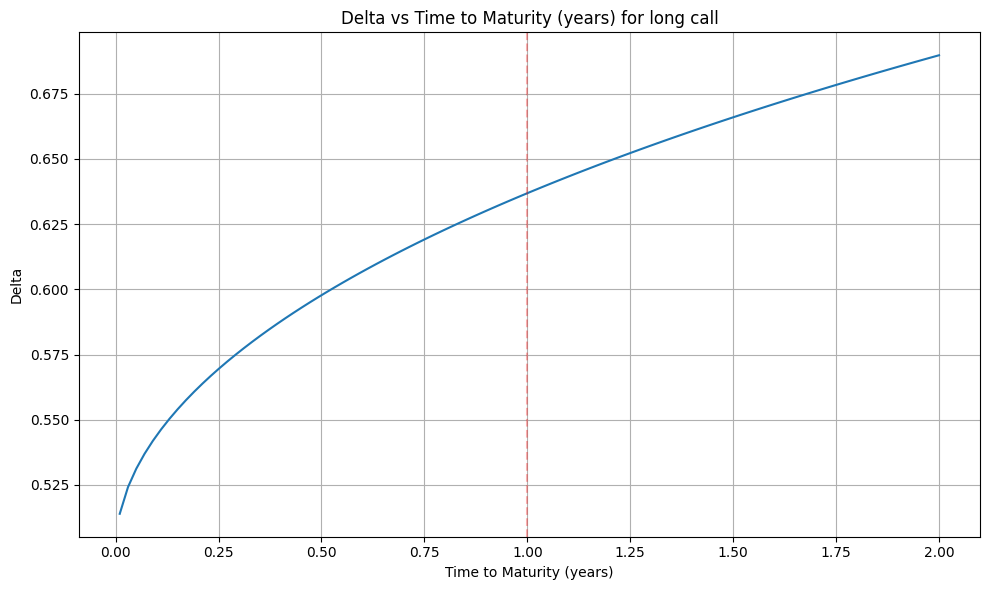

In [21]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, Dropdown, fixed

class BlackScholes:
    """
    A class for pricing options using the Black-Scholes model and calculating Greeks.
    
    Attributes:
        S0 (float): Current stock price (spot)
        K (float): Strike price
        r (float): Risk-free interest rate (annual)
        sigma (float): Implied volatility (annualized)
        T (float): Time to maturity (in years)
    """
    
    def __init__(self, S0, K, r, sigma, T):
        """
        Initialize Black-Scholes model with option parameters.
        
        Args:
            S0 (float): Current stock price (spot)
            K (float): Strike price
            r (float): Risk-free interest rate (annual)
            sigma (float): Implied volatility (annualized)
            T (float): Time to maturity (in years)
        """
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        
        # Calculate d1 and d2 (used in many formulas)
        self._update_d1_d2()
        
    def _update_d1_d2(self):
        """Update d1 and d2 values after any parameter change."""
        if self.T <= 0:
            self.d1 = np.nan
            self.d2 = np.nan
        else:
            self.d1 = (np.log(self.S0 / self.K) + (self.r + 0.5 * self.sigma**2) * self.T) / (self.sigma * np.sqrt(self.T))
            self.d2 = self.d1 - self.sigma * np.sqrt(self.T)
    
    def update_params(self, S0=None, K=None, r=None, sigma=None, T=None):
        """
        Update any of the model parameters.
        
        Args:
            S0 (float, optional): Current stock price
            K (float, optional): Strike price
            r (float, optional): Risk-free interest rate
            sigma (float, optional): Implied volatility
            T (float, optional): Time to maturity
        """
        if S0 is not None:
            self.S0 = S0
        if K is not None:
            self.K = K
        if r is not None:
            self.r = r
        if sigma is not None:
            self.sigma = sigma
        if T is not None:
            self.T = T
        
        self._update_d1_d2()
    
    def call_price(self):
        """Calculate the price of a call option."""
        if np.isnan(self.d1):
            return max(0, self.S0 - self.K)  # Intrinsic value at expiration
        
        return self.S0 * norm.cdf(self.d1) - self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2)
    
    def put_price(self):
        """Calculate the price of a put option."""
        if np.isnan(self.d1):
            return max(0, self.K - self.S0)  # Intrinsic value at expiration
        
        return self.K * np.exp(-self.r * self.T) * norm.cdf(-self.d2) - self.S0 * norm.cdf(-self.d1)
    
    def price(self, option_type, option_position='long'):
        """
        Calculate the price of an option.
        
        Args:
            option_type (str): 'call' or 'put'
            option_position (str): 'long' or 'short'
            
        Returns:
            float: Option price (positive for long, negative for short)
        """
        if option_type.lower() == 'call':
            price = self.call_price()
        elif option_type.lower() == 'put':
            price = self.put_price()
        else:
            raise ValueError("option_type must be 'call' or 'put'")
        
        if option_position.lower() == 'long':
            return price
        elif option_position.lower() == 'short':
            return -price
        else:
            raise ValueError("option_position must be 'long' or 'short'")
    
    # First-order Greeks
    
    def delta(self, option_type, option_position='long'):
        """
        Calculate the delta of an option (first derivative with respect to spot price).
        
        Args:
            option_type (str): 'call' or 'put'
            option_position (str): 'long' or 'short'
            
        Returns:
            float: Delta value
        """
        if np.isnan(self.d1):
            # At expiration, delta is either 0 or 1 (or -1 for short)
            if option_type.lower() == 'call':
                delta = 1 if self.S0 > self.K else 0
            else:  # put
                delta = -1 if self.S0 < self.K else 0
        else:
            if option_type.lower() == 'call':
                delta = norm.cdf(self.d1)
            elif option_type.lower() == 'put':
                delta = norm.cdf(self.d1) - 1
            else:
                raise ValueError("option_type must be 'call' or 'put'")
        
        if option_position.lower() == 'short':
            delta = -delta
            
        return delta
    
    def gamma(self, option_position='long'):
        """
        Calculate the gamma of an option (second derivative with respect to spot price).
        Same for both calls and puts.
        
        Args:
            option_position (str): 'long' or 'short'
            
        Returns:
            float: Gamma value
        """
        if np.isnan(self.d1):
            return 0  # Gamma is 0 at expiration
            
        gamma = norm.pdf(self.d1) / (self.S0 * self.sigma * np.sqrt(self.T))
        
        if option_position.lower() == 'short':
            gamma = -gamma
            
        return gamma
    
    def theta(self, option_type, option_position='long'):
        """
        Calculate the theta of an option (derivative with respect to time).
        
        Args:
            option_type (str): 'call' or 'put'
            option_position (str): 'long' or 'short'
            
        Returns:
            float: Theta value (daily)
        """
        if np.isnan(self.d1):
            return 0  # Theta is 0 at expiration
            
        # Common term for both call and put
        common_term = -(self.S0 * norm.pdf(self.d1) * self.sigma) / (2 * np.sqrt(self.T))
        
        if option_type.lower() == 'call':
            theta = common_term - self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2)
        elif option_type.lower() == 'put':
            theta = common_term + self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(-self.d2)
        else:
            raise ValueError("option_type must be 'call' or 'put'")
        
        # Convert from yearly to daily theta
        theta = theta / 365.0
        
        if option_position.lower() == 'short':
            theta = -theta
            
        return theta
    
    def vega(self, option_position='long'):
        """
        Calculate the vega of an option (derivative with respect to volatility).
        Same for both calls and puts.
        
        Args:
            option_position (str): 'long' or 'short'
            
        Returns:
            float: Vega value (for 1% change in volatility)
        """
        if np.isnan(self.d1):
            return 0  # Vega is 0 at expiration
            
        vega = self.S0 * np.sqrt(self.T) * norm.pdf(self.d1) * 0.01
        
        if option_position.lower() == 'short':
            vega = -vega
            
        return vega
    
    def rho(self, option_type, option_position='long'):
        """
        Calculate the rho of an option (derivative with respect to interest rate).
        
        Args:
            option_type (str): 'call' or 'put'
            option_position (str): 'long' or 'short'
            
        Returns:
            float: Rho value (for 1% change in interest rate)
        """
        if np.isnan(self.d1):
            return 0  # Rho is 0 at expiration
            
        if option_type.lower() == 'call':
            rho = self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(self.d2) * 0.01
        elif option_type.lower() == 'put':
            rho = -self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(-self.d2) * 0.01
        else:
            raise ValueError("option_type must be 'call' or 'put'")
        
        if option_position.lower() == 'short':
            rho = -rho
            
        return rho
    
    # Second-order Greeks
    
    def charm(self, option_type, option_position='long'):
        """
        Calculate the charm of an option (derivative of delta with respect to time).
        Also known as delta decay.
        
        Args:
            option_type (str): 'call' or 'put'
            option_position (str): 'long' or 'short'
            
        Returns:
            float: Charm value (daily)
        """
        if np.isnan(self.d1):
            return 0  # Charm is 0 at expiration
            
        d_pdf = norm.pdf(self.d1)
        
        charm = -d_pdf * ((self.r - self.d1 * self.sigma / (2 * np.sqrt(self.T))) / 
                         (self.sigma * np.sqrt(self.T)))
        
        if option_type.lower() == 'put':
            charm = -charm
        
        # Convert from yearly to daily
        charm = charm / 365.0
        
        if option_position.lower() == 'short':
            charm = -charm
            
        return charm
    
    def vanna(self, option_position='long'):
        """
        Calculate the vanna of an option (derivative of delta with respect to volatility).
        Or derivative of vega with respect to spot price.
        Same for both calls and puts.
        
        Args:
            option_position (str): 'long' or 'short'
            
        Returns:
            float: Vanna value
        """
        if np.isnan(self.d1):
            return 0  # Vanna is 0 at expiration
            
        vanna = -norm.pdf(self.d1) * (self.d2 / self.sigma)
        
        if option_position.lower() == 'short':
            vanna = -vanna
            
        return vanna
    
    def volga(self, option_position='long'):
        """
        Calculate the volga of an option (second derivative with respect to volatility).
        Also known as vomma. Same for both calls and puts.
        
        Args:
            option_position (str): 'long' or 'short'
            
        Returns:
            float: Volga value
        """
        if np.isnan(self.d1):
            return 0  # Volga is 0 at expiration
            
        vega = self.vega(option_position='long') * 100  # Vega for 1 point change (not %)
        volga = vega * (self.d1 * self.d2 / self.sigma)
        
        if option_position.lower() == 'short':
            volga = -volga
            
        return volga
    
    def veta(self, option_position='long'):
        """
        Calculate the veta of an option (derivative of vega with respect to time).
        Same for both calls and puts.
        
        Args:
            option_position (str): 'long' or 'short'
            
        Returns:
            float: Veta value (daily)
        """
        if np.isnan(self.d1):
            return 0  # Veta is 0 at expiration
            
        veta = -self.S0 * norm.pdf(self.d1) * np.sqrt(self.T) * (
            (self.r - self.d1 * self.sigma / (2 * np.sqrt(self.T))) /
            (self.sigma * np.sqrt(self.T))
        ) * 0.01
        
        # Convert from yearly to daily
        veta = veta / 365.0
        
        if option_position.lower() == 'short':
            veta = -veta
            
        return veta
    
    def get_greek(self, greek_name, option_type=None, option_position='long'):
        """
        Get a specific Greek value.
        
        Args:
            greek_name (str): Name of the Greek ('delta', 'gamma', etc.)
            option_type (str, optional): 'call' or 'put' (not needed for gamma, vega, vanna, volga)
            option_position (str): 'long' or 'short'
            
        Returns:
            float: Value of the specified Greek
        """
        greek_name = greek_name.lower()
        
        if greek_name in ['gamma', 'vega', 'vanna', 'volga', 'veta']:
            return getattr(self, greek_name)(option_position=option_position)
        elif greek_name in ['delta', 'theta', 'rho', 'charm']:
            if option_type is None:
                raise ValueError(f"{greek_name} requires option_type to be specified")
            return getattr(self, greek_name)(option_type=option_type, option_position=option_position)
        else:
            raise ValueError(f"Unknown greek: {greek_name}")
    
    def get_all_greeks(self, option_type, option_position='long'):
        """
        Get all Greeks for a specific option type and position.
        
        Args:
            option_type (str): 'call' or 'put'
            option_position (str): 'long' or 'short'
            
        Returns:
            dict: Dictionary with all Greek values
        """
        return {
            'delta': self.delta(option_type, option_position),
            'gamma': self.gamma(option_position),
            'theta': self.theta(option_type, option_position),
            'vega': self.vega(option_position),
            'rho': self.rho(option_type, option_position),
            'charm': self.charm(option_type, option_position),
            'vanna': self.vanna(option_position),
            'volga': self.volga(option_position),
            'veta': self.veta(option_position)
        }

def plot_greek_vs_parameter(
    greek, param_name, option_type, option_position='long',
    S0=100, K=100, r=0.05, sigma=0.2, T=1,
    param_range=None
):
    """
    Plot a Greek against a changing parameter.
    
    Args:
        greek (str): Name of the Greek to plot
        param_name (str): Name of the parameter to vary ('S0', 'K', 'r', 'sigma', 'T')
        option_type (str): 'call' or 'put'
        option_position (str): 'long' or 'short'
        S0, K, r, sigma, T: Default values for the Black-Scholes parameters
        param_range (tuple, optional): Range for the parameter (min, max, steps)
    """
    # Default ranges for parameters
    default_ranges = {
        'S0': (50, 150, 100),  # 50 to 150, 100 steps
        'K': (50, 150, 100),
        'r': (0, 0.1, 100),    # 0% to 10%, 100 steps
        'sigma': (0.05, 0.5, 100), # 5% to 50%, 100 steps
        'T': (0.01, 2, 100)    # 0.01 to 2 years, 100 steps
    }
    
    # Use provided range or default
    if param_range is None:
        param_range = default_ranges[param_name]
    
    min_val, max_val, steps = param_range
    x_values = np.linspace(min_val, max_val, steps)
    y_values = []
    
    for x in x_values:
        # Create BS model with the current parameter value
        params = {'S0': S0, 'K': K, 'r': r, 'sigma': sigma, 'T': T}
        params[param_name] = x
        
        bs = BlackScholes(**params)
        
        # Get the Greek value
        if greek in ['gamma', 'vega', 'vanna', 'volga', 'veta']:
            y = bs.get_greek(greek, option_position=option_position)
        else:
            y = bs.get_greek(greek, option_type=option_type, option_position=option_position)
        
        y_values.append(y)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, y_values)
    
    # Parameter-specific formatting
    param_labels = {
        'S0': 'Spot Price',
        'K': 'Strike Price',
        'r': 'Risk-Free Rate',
        'sigma': 'Implied Volatility',
        'T': 'Time to Maturity (years)'
    }
    
    greeks_labels = {
        'delta': 'Delta',
        'gamma': 'Gamma',
        'theta': 'Theta (daily)',
        'vega': 'Vega (1% change)',
        'rho': 'Rho (1% change)',
        'charm': 'Charm (daily)',
        'vanna': 'Vanna',
        'volga': 'Volga',
        'veta': 'Veta (daily)'
    }
    
    plt.title(f'{greeks_labels[greek]} vs {param_labels[param_name]} for {option_position} {option_type}')
    plt.xlabel(param_labels[param_name])
    plt.ylabel(greeks_labels[greek])
    plt.grid(True)
    
    # Add vertical line at the current parameter value
    current_value = {'S0': S0, 'K': K, 'r': r, 'sigma': sigma, 'T': T}[param_name]
    if min_val <= current_value <= max_val:
        plt.axvline(x=current_value, color='r', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def interactive_greek_analysis():
    """Create an interactive widget to explore Greeks vs parameters."""
    
    def update_plot(greek, param, option_type, option_position, S0, K, r, sigma, T):
        plot_greek_vs_parameter(
            greek, param, option_type, option_position, 
            S0, K, r, sigma, T
        )
    
    # Define the widgets
    greek_dropdown = Dropdown(
        options=['delta', 'gamma', 'theta', 'vega', 'rho', 'charm', 'vanna', 'volga', 'veta'],
        value='delta',
        description='Greek:'
    )
    
    param_dropdown = Dropdown(
        options=['S0', 'K', 'r', 'sigma', 'T'],
        value='S0',
        description='Parameter:'
    )
    
    option_type_dropdown = Dropdown(
        options=['call', 'put'],
        value='call',
        description='Option Type:'
    )
    
    option_position_dropdown = Dropdown(
        options=['long', 'short'],
        value='long',
        description='Position:'
    )
    
    S0_slider = FloatSlider(
        value=100.0, min=50.0, max=150.0, step=1.0,
        description='Spot Price:',
        continuous_update=False
    )
    
    K_slider = FloatSlider(
        value=100.0, min=50.0, max=150.0, step=1.0,
        description='Strike:',
        continuous_update=False
    )
    
    r_slider = FloatSlider(
        value=0.05, min=0.0, max=0.1, step=0.005,
        description='Rate:',
        continuous_update=False
    )
    
    sigma_slider = FloatSlider(
        value=0.2, min=0.05, max=0.5, step=0.01,
        description='Volatility:',
        continuous_update=False
    )
    
    T_slider = FloatSlider(
        value=1.0, min=0.01, max=2.0, step=0.01,
        description='Maturity:',
        continuous_update=False
    )
    
    # Create the interactive plot
    interact(
        update_plot,
        greek=greek_dropdown,
        param=param_dropdown,
        option_type=option_type_dropdown,
        option_position=option_position_dropdown,
        S0=S0_slider,
        K=K_slider,
        r=r_slider,
        sigma=sigma_slider,
        T=T_slider
    )

def option_price_calculator():
    """Interactive widget to calculate option prices and Greeks."""
    
    def update_calculation(option_type, option_position, S0, K, r, sigma, T):
        bs = BlackScholes(S0, K, r, sigma, T)
        price = bs.price(option_type, option_position)
        greeks = bs.get_all_greeks(option_type, option_position)
        
        print(f"Option: {option_position} {option_type}")
        print(f"Price: {price:.4f}")
        print("\nFirst-order Greeks:")
        print(f"Delta: {greeks['delta']:.4f}")
        print(f"Gamma: {greeks['gamma']:.4f}")
        print(f"Theta: {greeks['theta']:.4f} (daily)")
        print(f"Vega: {greeks['vega']:.4f} (for 1% change)")
        print(f"Rho: {greeks['rho']:.4f} (for 1% change)")
        print("\nSecond-order Greeks:")
        print(f"Charm: {greeks['charm']:.4f} (daily)")
        print(f"Vanna: {greeks['vanna']:.4f}")
        print(f"Volga: {greeks['volga']:.4f}")
        print(f"Veta: {greeks['veta']:.4f} (daily)")
    
    # Define the widgets
    option_type_dropdown = Dropdown(
        options=['call', 'put'],
        value='call',
        description='Option Type:'
    )
    
    option_position_dropdown = Dropdown(
        options=['long', 'short'],
        value='long',
        description='Position:'
    )
    
    S0_slider = FloatSlider(
        value=100.0, min=50.0, max=150.0, step=1.0,
        description='Spot Price:',
        continuous_update=False
    )
    
    K_slider = FloatSlider(
        value=100.0, min=50.0, max=150.0, step=1.0,
        description='Strike:',
        continuous_update=False
    )
    
    r_slider = FloatSlider(
        value=0.05, min=0.0, max=0.1, step=0.005,
        description='Rate:',
        continuous_update=False
    )
    
    sigma_slider = FloatSlider(
        value=0.2, min=0.05, max=0.5, step=0.01,
        description='Volatility:',
        continuous_update=False
    )
    
    T_slider = FloatSlider(
        value=1.0, min=0.01, max=2.0, step=0.01,
        description='Maturity:',
        continuous_update=False
    )
    
    # Create the interactive calculator
    interact(
        update_calculation,
        option_type=option_type_dropdown,
        option_position=option_position_dropdown,
        S0=S0_slider,
        K=K_slider,
        r=r_slider,
        sigma=sigma_slider,
        T=T_slider
    )

# Example usage
if __name__ == "__main__":
    # Create an instance with default parameters
    bs = BlackScholes(S0=100, K=100, r=0.1, sigma=0.01, T=1)
    
    # Calculate prices for different options
    call_price = bs.price('call', 'long')
    put_price = bs.price('put', 'long')
    short_call_price = bs.price('call', 'short')
    
    print(f"Long Call Price: {call_price:.4f}")
    print(f"Long Put Price: {put_price:.4f}")
    print(f"Short Call Price: {short_call_price:.4f}")
    
    # Calculate Greeks for a long call
    long_call_greeks = bs.get_all_greeks('call', 'long')
    print("\nLong Call Greeks:")
    for greek, value in long_call_greeks.items():
        print(f"{greek}: {value:.4f}")
    
    # Plot delta vs spot price for a long call
    plot_greek_vs_parameter('delta', 'T', 'call', 'long')


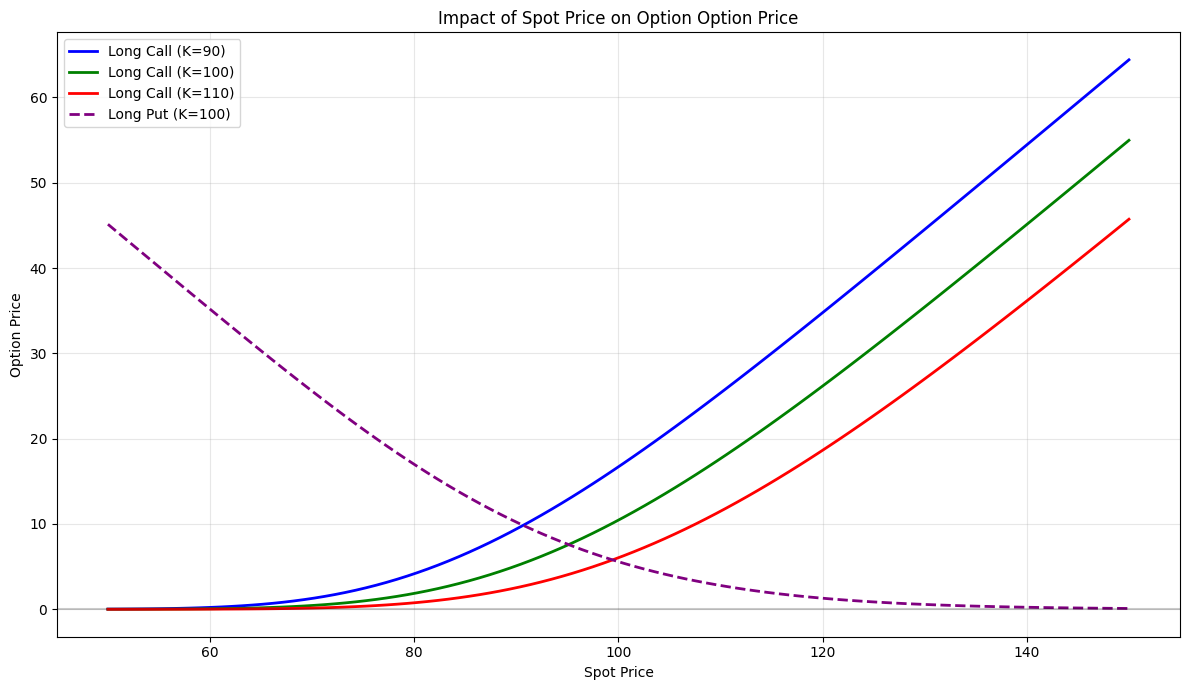

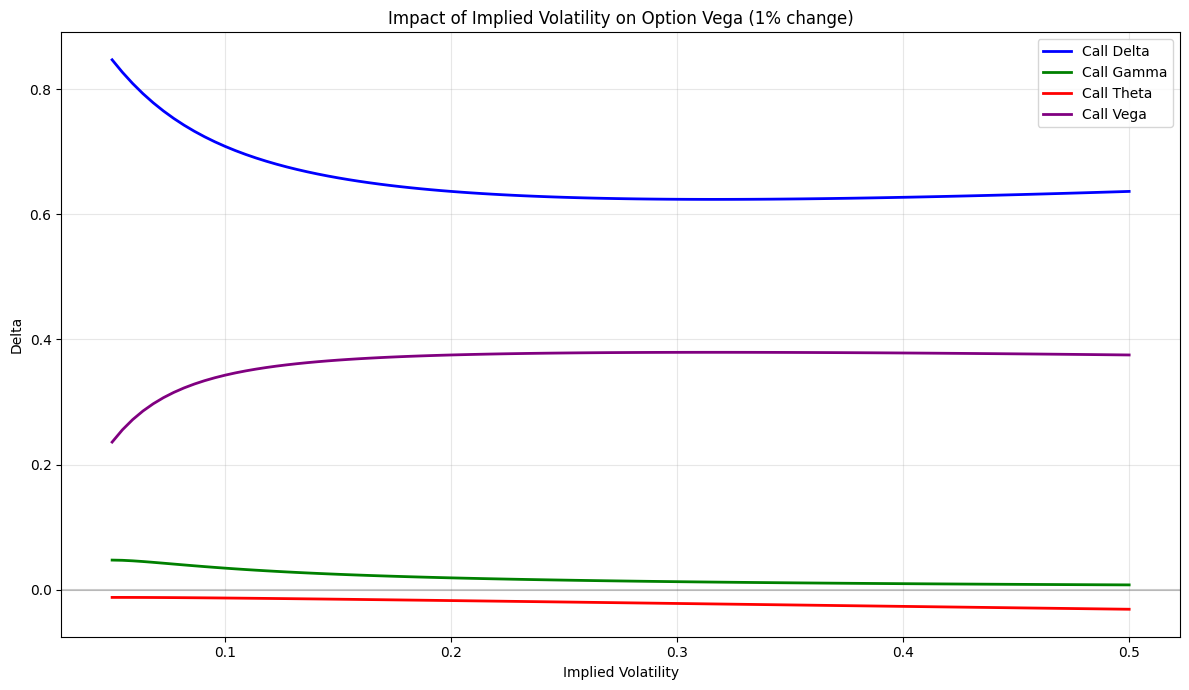

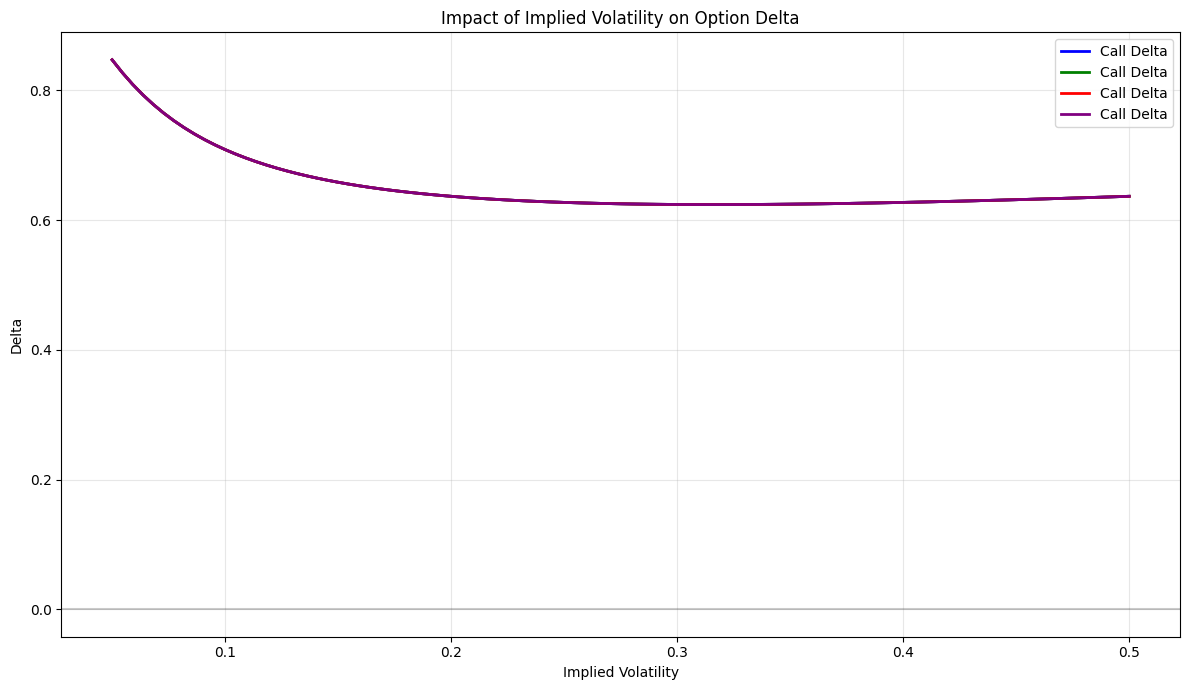

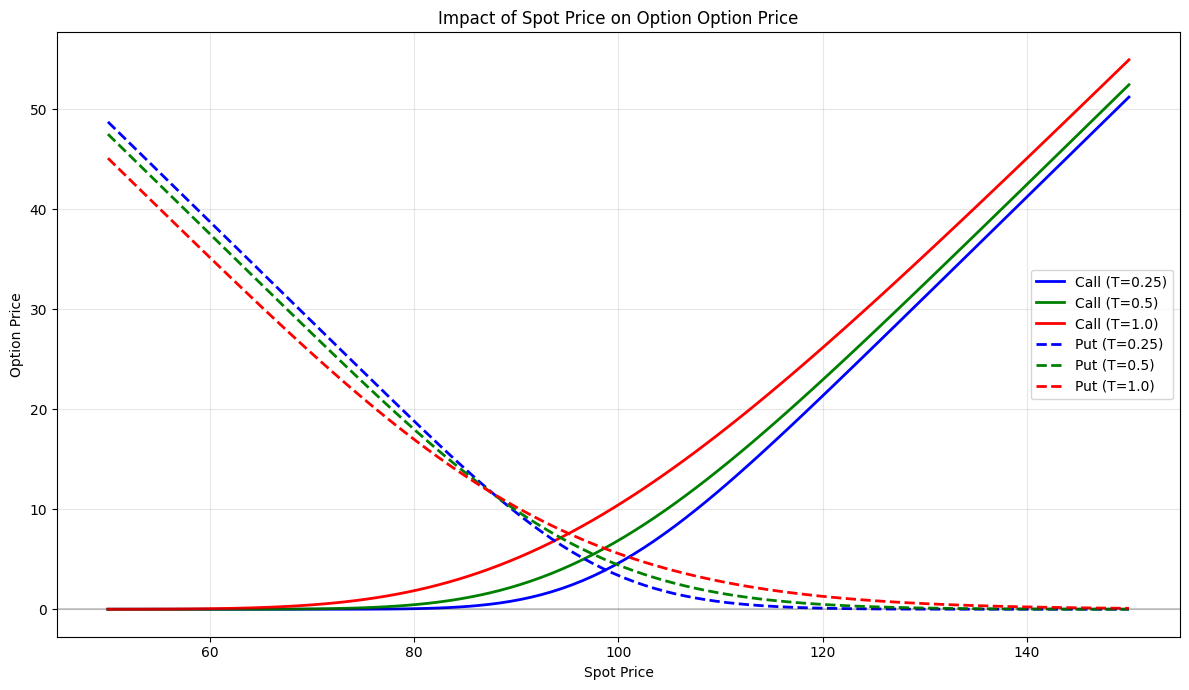

In [20]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, Dropdown, fixed

class BlackScholes:
    """
    A class for pricing options using the Black-Scholes model and calculating Greeks.
    
    Attributes:
        S0 (float): Current stock price (spot)
        K (float): Strike price
        r (float): Risk-free interest rate (annual)
        sigma (float): Implied volatility (annualized)
        T (float): Time to maturity (in years)
    """
    
    def __init__(self, S0, K, r, sigma, T):
        """
        Initialize Black-Scholes model with option parameters.
        
        Args:
            S0 (float): Current stock price (spot)
            K (float): Strike price
            r (float): Risk-free interest rate (annual)
            sigma (float): Implied volatility (annualized)
            T (float): Time to maturity (in years)
        """
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        
        # Calculate d1 and d2 (used in many formulas)
        self._update_d1_d2()
        
    def _update_d1_d2(self):
        """Update d1 and d2 values after any parameter change."""
        if self.T <= 0:
            self.d1 = np.nan
            self.d2 = np.nan
        else:
            self.d1 = (np.log(self.S0 / self.K) + (self.r + 0.5 * self.sigma**2) * self.T) / (self.sigma * np.sqrt(self.T))
            self.d2 = self.d1 - self.sigma * np.sqrt(self.T)
    
    def update_params(self, S0=None, K=None, r=None, sigma=None, T=None):
        """
        Update any of the model parameters.
        
        Args:
            S0 (float, optional): Current stock price
            K (float, optional): Strike price
            r (float, optional): Risk-free interest rate
            sigma (float, optional): Implied volatility
            T (float, optional): Time to maturity
        """
        if S0 is not None:
            self.S0 = S0
        if K is not None:
            self.K = K
        if r is not None:
            self.r = r
        if sigma is not None:
            self.sigma = sigma
        if T is not None:
            self.T = T
        
        self._update_d1_d2()
    
    def call_price(self):
        """Calculate the price of a call option."""
        if np.isnan(self.d1):
            return max(0, self.S0 - self.K)  # Intrinsic value at expiration
        
        return self.S0 * norm.cdf(self.d1) - self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2)
    
    def put_price(self):
        """Calculate the price of a put option."""
        if np.isnan(self.d1):
            return max(0, self.K - self.S0)  # Intrinsic value at expiration
        
        return self.K * np.exp(-self.r * self.T) * norm.cdf(-self.d2) - self.S0 * norm.cdf(-self.d1)
    
    def price(self, option_type, option_position='long'):
        """
        Calculate the price of an option.
        
        Args:
            option_type (str): 'call' or 'put'
            option_position (str): 'long' or 'short'
            
        Returns:
            float: Option price (positive for long, negative for short)
        """
        if option_type.lower() == 'call':
            price = self.call_price()
        elif option_type.lower() == 'put':
            price = self.put_price()
        else:
            raise ValueError("option_type must be 'call' or 'put'")
        
        if option_position.lower() == 'long':
            return price
        elif option_position.lower() == 'short':
            return -price
        else:
            raise ValueError("option_position must be 'long' or 'short'")
    
    # First-order Greeks
    
    def delta(self, option_type, option_position='long'):
        """
        Calculate the delta of an option (first derivative with respect to spot price).
        
        Args:
            option_type (str): 'call' or 'put'
            option_position (str): 'long' or 'short'
            
        Returns:
            float: Delta value
        """
        if np.isnan(self.d1):
            # At expiration, delta is either 0 or 1 (or -1 for short)
            if option_type.lower() == 'call':
                delta = 1 if self.S0 > self.K else 0
            else:  # put
                delta = -1 if self.S0 < self.K else 0
        else:
            if option_type.lower() == 'call':
                delta = norm.cdf(self.d1)
            elif option_type.lower() == 'put':
                delta = norm.cdf(self.d1) - 1
            else:
                raise ValueError("option_type must be 'call' or 'put'")
        
        if option_position.lower() == 'short':
            delta = -delta
            
        return delta
    
    def gamma(self, option_position='long'):
        """
        Calculate the gamma of an option (second derivative with respect to spot price).
        Same for both calls and puts.
        
        Args:
            option_position (str): 'long' or 'short'
            
        Returns:
            float: Gamma value
        """
        if np.isnan(self.d1):
            return 0  # Gamma is 0 at expiration
            
        gamma = norm.pdf(self.d1) / (self.S0 * self.sigma * np.sqrt(self.T))
        
        if option_position.lower() == 'short':
            gamma = -gamma
            
        return gamma
    
    def theta(self, option_type, option_position='long'):
        """
        Calculate the theta of an option (derivative with respect to time).
        
        Args:
            option_type (str): 'call' or 'put'
            option_position (str): 'long' or 'short'
            
        Returns:
            float: Theta value (daily)
        """
        if np.isnan(self.d1):
            return 0  # Theta is 0 at expiration
            
        # Common term for both call and put
        common_term = -(self.S0 * norm.pdf(self.d1) * self.sigma) / (2 * np.sqrt(self.T))
        
        if option_type.lower() == 'call':
            theta = common_term - self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2)
        elif option_type.lower() == 'put':
            theta = common_term + self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(-self.d2)
        else:
            raise ValueError("option_type must be 'call' or 'put'")
        
        # Convert from yearly to daily theta
        theta = theta / 365.0
        
        if option_position.lower() == 'short':
            theta = -theta
            
        return theta
    
    def vega(self, option_position='long'):
        """
        Calculate the vega of an option (derivative with respect to volatility).
        Same for both calls and puts.
        
        Args:
            option_position (str): 'long' or 'short'
            
        Returns:
            float: Vega value (for 1% change in volatility)
        """
        if np.isnan(self.d1):
            return 0  # Vega is 0 at expiration
            
        vega = self.S0 * np.sqrt(self.T) * norm.pdf(self.d1) * 0.01
        
        if option_position.lower() == 'short':
            vega = -vega
            
        return vega
    
    def rho(self, option_type, option_position='long'):
        """
        Calculate the rho of an option (derivative with respect to interest rate).
        
        Args:
            option_type (str): 'call' or 'put'
            option_position (str): 'long' or 'short'
            
        Returns:
            float: Rho value (for 1% change in interest rate)
        """
        if np.isnan(self.d1):
            return 0  # Rho is 0 at expiration
            
        if option_type.lower() == 'call':
            rho = self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(self.d2) * 0.01
        elif option_type.lower() == 'put':
            rho = -self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(-self.d2) * 0.01
        else:
            raise ValueError("option_type must be 'call' or 'put'")
        
        if option_position.lower() == 'short':
            rho = -rho
            
        return rho
    
    # Second-order Greeks
    
    def charm(self, option_type, option_position='long'):
        """
        Calculate the charm of an option (derivative of delta with respect to time).
        Also known as delta decay.
        
        Args:
            option_type (str): 'call' or 'put'
            option_position (str): 'long' or 'short'
            
        Returns:
            float: Charm value (daily)
        """
        if np.isnan(self.d1):
            return 0  # Charm is 0 at expiration
            
        d_pdf = norm.pdf(self.d1)
        
        charm = -d_pdf * ((self.r - self.d1 * self.sigma / (2 * np.sqrt(self.T))) / 
                         (self.sigma * np.sqrt(self.T)))
        
        if option_type.lower() == 'put':
            charm = -charm
        
        # Convert from yearly to daily
        charm = charm / 365.0
        
        if option_position.lower() == 'short':
            charm = -charm
            
        return charm
    
    def vanna(self, option_position='long'):
        """
        Calculate the vanna of an option (derivative of delta with respect to volatility).
        Or derivative of vega with respect to spot price.
        Same for both calls and puts.
        
        Args:
            option_position (str): 'long' or 'short'
            
        Returns:
            float: Vanna value
        """
        if np.isnan(self.d1):
            return 0  # Vanna is 0 at expiration
            
        vanna = -norm.pdf(self.d1) * (self.d2 / self.sigma)
        
        if option_position.lower() == 'short':
            vanna = -vanna
            
        return vanna
    
    def volga(self, option_position='long'):
        """
        Calculate the volga of an option (second derivative with respect to volatility).
        Also known as vomma. Same for both calls and puts.
        
        Args:
            option_position (str): 'long' or 'short'
            
        Returns:
            float: Volga value
        """
        if np.isnan(self.d1):
            return 0  # Volga is 0 at expiration
            
        vega = self.vega(option_position='long') * 100  # Vega for 1 point change (not %)
        volga = vega * (self.d1 * self.d2 / self.sigma)
        
        if option_position.lower() == 'short':
            volga = -volga
            
        return volga
    
    def veta(self, option_position='long'):
        """
        Calculate the veta of an option (derivative of vega with respect to time).
        Same for both calls and puts.
        
        Args:
            option_position (str): 'long' or 'short'
            
        Returns:
            float: Veta value (daily)
        """
        if np.isnan(self.d1):
            return 0  # Veta is 0 at expiration
            
        veta = -self.S0 * norm.pdf(self.d1) * np.sqrt(self.T) * (
            (self.r - self.d1 * self.sigma / (2 * np.sqrt(self.T))) /
            (self.sigma * np.sqrt(self.T))
        ) * 0.01
        
        # Convert from yearly to daily
        veta = veta / 365.0
        
        if option_position.lower() == 'short':
            veta = -veta
            
        return veta
    
    def get_greek(self, greek_name, option_type=None, option_position='long'):
        """
        Get a specific Greek value.
        
        Args:
            greek_name (str): Name of the Greek ('delta', 'gamma', etc.)
            option_type (str, optional): 'call' or 'put' (not needed for gamma, vega, vanna, volga)
            option_position (str): 'long' or 'short'
            
        Returns:
            float: Value of the specified Greek
        """
        greek_name = greek_name.lower()
        
        if greek_name in ['gamma', 'vega', 'vanna', 'volga', 'veta']:
            return getattr(self, greek_name)(option_position=option_position)
        elif greek_name in ['delta', 'theta', 'rho', 'charm']:
            if option_type is None:
                raise ValueError(f"{greek_name} requires option_type to be specified")
            return getattr(self, greek_name)(option_type=option_type, option_position=option_position)
        else:
            raise ValueError(f"Unknown greek: {greek_name}")
    
    def get_all_greeks(self, option_type, option_position='long'):
        """
        Get all Greeks for a specific option type and position.
        
        Args:
            option_type (str): 'call' or 'put'
            option_position (str): 'long' or 'short'
            
        Returns:
            dict: Dictionary with all Greek values
        """
        return {
            'delta': self.delta(option_type, option_position),
            'gamma': self.gamma(option_position),
            'theta': self.theta(option_type, option_position),
            'vega': self.vega(option_position),
            'rho': self.rho(option_type, option_position),
            'charm': self.charm(option_type, option_position),
            'vanna': self.vanna(option_position),
            'volga': self.volga(option_position),
            'veta': self.veta(option_position)
        }

def plot_greek_vs_parameter(
    greek, param_name, option_type, option_position='long',
    S0=100, K=100, r=0.05, sigma=0.2, T=1,
    param_range=None
):
    """
    Plot a Greek against a changing parameter.
    
    Args:
        greek (str): Name of the Greek to plot
        param_name (str): Name of the parameter to vary ('S0', 'K', 'r', 'sigma', 'T')
        option_type (str): 'call' or 'put'
        option_position (str): 'long' or 'short'
        S0, K, r, sigma, T: Default values for the Black-Scholes parameters
        param_range (tuple, optional): Range for the parameter (min, max, steps)
    """
    # Default ranges for parameters
    default_ranges = {
        'S0': (50, 150, 100),  # 50 to 150, 100 steps
        'K': (50, 150, 100),
        'r': (0, 0.1, 100),    # 0% to 10%, 100 steps
        'sigma': (0.05, 0.5, 100), # 5% to 50%, 100 steps
        'T': (0.01, 2, 100)    # 0.01 to 2 years, 100 steps
    }
    
    # Use provided range or default
    if param_range is None:
        param_range = default_ranges[param_name]
    
    min_val, max_val, steps = param_range
    x_values = np.linspace(min_val, max_val, steps)
    y_values = []
    
    for x in x_values:
        # Create BS model with the current parameter value
        params = {'S0': S0, 'K': K, 'r': r, 'sigma': sigma, 'T': T}
        params[param_name] = x
        
        bs = BlackScholes(**params)
        
        # Get the Greek value
        if greek in ['gamma', 'vega', 'vanna', 'volga', 'veta']:
            y = bs.get_greek(greek, option_position=option_position)
        else:
            y = bs.get_greek(greek, option_type=option_type, option_position=option_position)
        
        y_values.append(y)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, y_values)
    
    # Parameter-specific formatting
    param_labels = {
        'S0': 'Spot Price',
        'K': 'Strike Price',
        'r': 'Risk-Free Rate',
        'sigma': 'Implied Volatility',
        'T': 'Time to Maturity (years)'
    }
    
    greeks_labels = {
        'delta': 'Delta',
        'gamma': 'Gamma',
        'theta': 'Theta (daily)',
        'vega': 'Vega (1% change)',
        'rho': 'Rho (1% change)',
        'charm': 'Charm (daily)',
        'vanna': 'Vanna',
        'volga': 'Volga',
        'veta': 'Veta (daily)'
    }
    
    plt.title(f'{greeks_labels[greek]} vs {param_labels[param_name]} for {option_position} {option_type}')
    plt.xlabel(param_labels[param_name])
    plt.ylabel(greeks_labels[greek])
    plt.grid(True)
    
    # Add vertical line at the current parameter value
    current_value = {'S0': S0, 'K': K, 'r': r, 'sigma': sigma, 'T': T}[param_name]
    if min_val <= current_value <= max_val:
        plt.axvline(x=current_value, color='r', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def interactive_greek_analysis():
    """Create an interactive widget to explore Greeks vs parameters."""
    
    def update_plot(greek, param, option_type, option_position, S0, K, r, sigma, T):
        plot_greek_vs_parameter(
            greek, param, option_type, option_position, 
            S0, K, r, sigma, T
        )
    
    # Define the widgets
    greek_dropdown = Dropdown(
        options=['delta', 'gamma', 'theta', 'vega', 'rho', 'charm', 'vanna', 'volga', 'veta'],
        value='delta',
        description='Greek:'
    )
    
    param_dropdown = Dropdown(
        options=['S0', 'K', 'r', 'sigma', 'T'],
        value='S0',
        description='Parameter:'
    )
    
    option_type_dropdown = Dropdown(
        options=['call', 'put'],
        value='call',
        description='Option Type:'
    )
    
    option_position_dropdown = Dropdown(
        options=['long', 'short'],
        value='long',
        description='Position:'
    )
    
    S0_slider = FloatSlider(
        value=100.0, min=50.0, max=150.0, step=1.0,
        description='Spot Price:',
        continuous_update=False
    )
    
    K_slider = FloatSlider(
        value=100.0, min=50.0, max=150.0, step=1.0,
        description='Strike:',
        continuous_update=False
    )
    
    r_slider = FloatSlider(
        value=0.05, min=0.0, max=0.1, step=0.005,
        description='Rate:',
        continuous_update=False
    )
    
    sigma_slider = FloatSlider(
        value=0.2, min=0.05, max=0.5, step=0.01,
        description='Volatility:',
        continuous_update=False
    )
    
    T_slider = FloatSlider(
        value=1.0, min=0.01, max=2.0, step=0.01,
        description='Maturity:',
        continuous_update=False
    )
    
    # Create the interactive plot
    interact(
        update_plot,
        greek=greek_dropdown,
        param=param_dropdown,
        option_type=option_type_dropdown,
        option_position=option_position_dropdown,
        S0=S0_slider,
        K=K_slider,
        r=r_slider,
        sigma=sigma_slider,
        T=T_slider
    )

def option_price_calculator():
    """Interactive widget to calculate option prices and Greeks."""
    
    def update_calculation(option_type, option_position, S0, K, r, sigma, T):
        bs = BlackScholes(S0, K, r, sigma, T)
        price = bs.price(option_type, option_position)
        greeks = bs.get_all_greeks(option_type, option_position)
        
        print(f"Option: {option_position} {option_type}")
        print(f"Price: {price:.4f}")
        print("\nFirst-order Greeks:")
        print(f"Delta: {greeks['delta']:.4f}")
        print(f"Gamma: {greeks['gamma']:.4f}")
        print(f"Theta: {greeks['theta']:.4f} (daily)")
        print(f"Vega: {greeks['vega']:.4f} (for 1% change)")
        print(f"Rho: {greeks['rho']:.4f} (for 1% change)")
        print("\nSecond-order Greeks:")
        print(f"Charm: {greeks['charm']:.4f} (daily)")
        print(f"Vanna: {greeks['vanna']:.4f}")
        print(f"Volga: {greeks['volga']:.4f}")
        print(f"Veta: {greeks['veta']:.4f} (daily)")
    
    # Define the widgets
    option_type_dropdown = Dropdown(
        options=['call', 'put'],
        value='call',
        description='Option Type:'
    )
    
    option_position_dropdown = Dropdown(
        options=['long', 'short'],
        value='long',
        description='Position:'
    )
    
    S0_slider = FloatSlider(
        value=100.0, min=50.0, max=150.0, step=1.0,
        description='Spot Price:',
        continuous_update=False
    )
    
    K_slider = FloatSlider(
        value=100.0, min=50.0, max=150.0, step=1.0,
        description='Strike:',
        continuous_update=False
    )
    
    r_slider = FloatSlider(
        value=0.05, min=0.0, max=0.1, step=0.005,
        description='Rate:',
        continuous_update=False
    )
    
    sigma_slider = FloatSlider(
        value=0.2, min=0.05, max=0.5, step=0.01,
        description='Volatility:',
        continuous_update=False
    )
    
    T_slider = FloatSlider(
        value=1.0, min=0.01, max=2.0, step=0.01,
        description='Maturity:',
        continuous_update=False
    )
    
    # Create the interactive calculator
    interact(
        update_calculation,
        option_type=option_type_dropdown,
        option_position=option_position_dropdown,
        S0=S0_slider,
        K=K_slider,
        r=r_slider,
        sigma=sigma_slider,
        T=T_slider
    )
    
def plot_option_comparison(options_list, param_name, fixed_params=None, param_range=None):
    """
    Plot multiple option configurations on the same chart by varying a parameter.
    
    Args:
        options_list (list): List of dictionaries, each with:
            - 'option_type': 'call' or 'put'
            - 'option_position': 'long' or 'short'
            - 'greek': Name of the Greek to plot (or 'price' for option price)
            - 'S0', 'K', 'r', 'sigma', 'T': Option specific parameters (optional)
            - 'label': Label for the line (optional)
            - 'color': Color for the line (optional)
            - 'linestyle': Style for the line (optional)
        param_name (str): Name of the parameter to vary ('S0', 'K', 'r', 'sigma', 'T')
        fixed_params (dict, optional): Default values for all options unless overridden
                                      {'S0': 100, 'K': 100, 'r': 0.05, 'sigma': 0.2, 'T': 1}
        param_range (tuple, optional): Range for the parameter (min, max, steps)
    
    Returns:
        matplotlib.figure.Figure: The figure object for further customization
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Default parameters if not specified
    if fixed_params is None:
        fixed_params = {'S0': 100, 'K': 100, 'r': 0.05, 'sigma': 0.2, 'T': 1}
    
    # Default ranges for parameters
    default_ranges = {
        'S0': (50, 150, 100),    # 50 to 150, 100 steps
        'K': (50, 150, 100),
        'r': (0, 0.1, 100),      # 0% to 10%, 100 steps
        'sigma': (0.05, 0.5, 100), # 5% to 50%, 100 steps
        'T': (0.01, 2, 100)      # 0.01 to 2 years, 100 steps
    }
    
    # Use provided range or default
    if param_range is None:
        param_range = default_ranges[param_name]
    
    min_val, max_val, steps = param_range
    x_values = np.linspace(min_val, max_val, steps)
    
    # Create the plot
    plt.figure(figsize=(12, 7))
    
    # Parameter-specific formatting
    param_labels = {
        'S0': 'Spot Price',
        'K': 'Strike Price',
        'r': 'Risk-Free Rate',
        'sigma': 'Implied Volatility',
        'T': 'Time to Maturity (years)'
    }
    
    greeks_labels = {
        'price': 'Option Price',
        'delta': 'Delta',
        'gamma': 'Gamma',
        'theta': 'Theta (daily)',
        'vega': 'Vega (1% change)',
        'rho': 'Rho (1% change)',
        'charm': 'Charm (daily)',
        'vanna': 'Vanna',
        'volga': 'Volga',
        'veta': 'Veta (daily)'
    }
    
    # Plot each option configuration
    for i, option_config in enumerate(options_list):
        # Extract option parameters, use defaults if not provided
        option_type = option_config.get('option_type', 'call')
        option_position = option_config.get('option_position', 'long')
        greek = option_config.get('greek', 'price')
        
        # Get option-specific parameters or use defaults
        params = fixed_params.copy()
        for key in ['S0', 'K', 'r', 'sigma', 'T']:
            if key in option_config:
                params[key] = option_config[key]
        
        # Line formatting
        line_props = {
            'label': option_config.get('label', f"{option_position} {option_type} {greek}"),
            'color': option_config.get('color', None),  # Let matplotlib choose if not specified
            'linestyle': option_config.get('linestyle', None),
            'linewidth': option_config.get('linewidth', 2)
        }
        
        # Remove None values to use matplotlib defaults
        line_props = {k: v for k, v in line_props.items() if v is not None}
        
        # Calculate values for each point in the parameter range
        y_values = []
        for x in x_values:
            # Create a new parameter set with the current value
            current_params = params.copy()
            current_params[param_name] = x
            
            # Create BS model with these parameters
            bs = BlackScholes(
                S0=current_params['S0'],
                K=current_params['K'],
                r=current_params['r'],
                sigma=current_params['sigma'],
                T=current_params['T']
            )
            
            # Get the value based on what we're plotting
            if greek == 'price':
                y = bs.price(option_type, option_position)
            elif greek in ['gamma', 'vega', 'vanna', 'volga', 'veta']:
                y = bs.get_greek(greek, option_position=option_position)
            else:
                y = bs.get_greek(greek, option_type=option_type, option_position=option_position)
            
            y_values.append(y)
        
        # Plot the line
        plt.plot(x_values, y_values, **line_props)
    
    # Add title, labels, and grid
    plot_title = f'Impact of {param_labels[param_name]} on Option {greeks_labels.get(greek, greek)}'
    plt.title(plot_title)
    plt.xlabel(param_labels[param_name])
    
    # Determine y-label based on what most options are measuring
    if len(options_list) > 0:
        main_greek = options_list[0].get('greek', 'price')
        plt.ylabel(greeks_labels.get(main_greek, main_greek))
    
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.2)  # Add a horizontal line at y=0
    
    # Add vertical line at a reference value if specified
    if 'reference_value' in fixed_params:
        ref = fixed_params['reference_value']
        if min_val <= ref <= max_val:
            plt.axvline(x=ref, color='r', linestyle='--', alpha=0.3, 
                        label=f"Reference {param_name}={ref}")
    
    plt.legend()
    plt.tight_layout()
    
    return plt.gcf()  # Return the figure for further customization

def interactive_comparison():
    """Create an interactive widget to compare multiple options."""
    from ipywidgets import interact, interactive, fixed, Layout
    from ipywidgets import FloatSlider, Dropdown, Text, Checkbox, VBox, HBox, Button, Output
    import ipywidgets as widgets
    
    # Store the current options
    options_store = []
    output = Output()
    
    # Main parameter sliders (defaults for all options)
    param_dropdown = Dropdown(
        options=['S0', 'K', 'r', 'sigma', 'T'],
        value='S0',
        description='Vary Parameter:'
    )
    
    S0_slider = FloatSlider(
        value=100.0, min=50.0, max=150.0, step=1.0,
        description='Spot Price:',
        continuous_update=False
    )
    
    K_slider = FloatSlider(
        value=100.0, min=50.0, max=150.0, step=1.0,
        description='Strike:',
        continuous_update=False
    )
    
    r_slider = FloatSlider(
        value=0.05, min=0.0, max=0.1, step=0.005,
        description='Rate:',
        continuous_update=False
    )
    
    sigma_slider = FloatSlider(
        value=0.2, min=0.05, max=0.5, step=0.01,
        description='Volatility:',
        continuous_update=False
    )
    
    T_slider = FloatSlider(
        value=1.0, min=0.01, max=2.0, step=0.01,
        description='Maturity:',
        continuous_update=False
    )
    
    # Option configuration widgets
    option_type_dropdown = Dropdown(
        options=['call', 'put'],
        value='call',
        description='Type:'
    )
    
    option_position_dropdown = Dropdown(
        options=['long', 'short'],
        value='long',
        description='Position:'
    )
    
    greek_dropdown = Dropdown(
        options=['price', 'delta', 'gamma', 'theta', 'vega', 'rho', 'charm', 'vanna', 'volga', 'veta'],
        value='price',
        description='Value to plot:'
    )
    
    label_text = Text(
        value='',
        placeholder='Auto-generate label',
        description='Label:',
        disabled=False
    )
    
    # Override checkboxes
    override_S0 = Checkbox(value=False, description='Override S0')
    override_K = Checkbox(value=False, description='Override K')
    override_r = Checkbox(value=False, description='Override r')
    override_sigma = Checkbox(value=False, description='Override sigma')
    override_T = Checkbox(value=False, description='Override T')
    
    # Override sliders (initially disabled)
    option_S0_slider = FloatSlider(
        value=100.0, min=50.0, max=150.0, step=1.0,
        description='Option S0:',
        disabled=True,
        continuous_update=False
    )
    
    option_K_slider = FloatSlider(
        value=100.0, min=50.0, max=150.0, step=1.0,
        description='Option K:',
        disabled=True,
        continuous_update=False
    )
    
    option_r_slider = FloatSlider(
        value=0.05, min=0.0, max=0.1, step=0.005,
        description='Option r:',
        disabled=True,
        continuous_update=False
    )
    
    option_sigma_slider = FloatSlider(
        value=0.2, min=0.05, max=0.5, step=0.01,
        description='Option σ:',
        disabled=True,
        continuous_update=False
    )
    
    option_T_slider = FloatSlider(
        value=1.0, min=0.01, max=2.0, step=0.01,
        description='Option T:',
        disabled=True,
        continuous_update=False
    )
    
    # Buttons
    add_button = Button(description="Add Option", button_style='success')
    clear_button = Button(description="Clear All", button_style='danger')
    plot_button = Button(description="Plot", button_style='info')
    
    # Enable/disable override sliders
    def update_override_S0(change):
        option_S0_slider.disabled = not change['new']
    
    def update_override_K(change):
        option_K_slider.disabled = not change['new']
    
    def update_override_r(change):
        option_r_slider.disabled = not change['new']
    
    def update_override_sigma(change):
        option_sigma_slider.disabled = not change['new']
    
    def update_override_T(change):
        option_T_slider.disabled = not change['new']
    
    override_S0.observe(update_override_S0, names='value')
    override_K.observe(update_override_K, names='value')
    override_r.observe(update_override_r, names='value')
    override_sigma.observe(update_override_sigma, names='value')
    override_T.observe(update_override_T, names='value')
    
    # Button click handlers
    def add_option_clicked(b):
        # Collect current option configuration
        option_config = {
            'option_type': option_type_dropdown.value,
            'option_position': option_position_dropdown.value,
            'greek': greek_dropdown.value,
            'label': label_text.value or None,  # Use None to auto-generate
        }
        
        # Add overridden parameters
        if override_S0.value:
            option_config['S0'] = option_S0_slider.value
        if override_K.value:
            option_config['K'] = option_K_slider.value
        if override_r.value:
            option_config['r'] = option_r_slider.value
        if override_sigma.value:
            option_config['sigma'] = option_sigma_slider.value
        if override_T.value:
            option_config['T'] = option_T_slider.value
        
        # Add to store
        options_store.append(option_config)
        
        # Update output
        with output:
            output.clear_output()
            print(f"Options to plot ({len(options_store)}):")
            for i, opt in enumerate(options_store):
                label = opt.get('label') or f"{opt['option_position']} {opt['option_type']} {opt['greek']}"
                overrides = []
                for param in ['S0', 'K', 'r', 'sigma', 'T']:
                    if param in opt:
                        overrides.append(f"{param}={opt[param]}")
                
                override_str = f" ({', '.join(overrides)})" if overrides else ""
                print(f"{i+1}. {label}{override_str}")
    
    def clear_options_clicked(b):
        options_store.clear()
        with output:
            output.clear_output()
            print("All options cleared.")
    
    def plot_clicked(b):
        if not options_store:
            with output:
                output.clear_output()
                print("Please add at least one option before plotting.")
            return
        
        # Collect fixed parameters
        fixed_params = {
            'S0': S0_slider.value,
            'K': K_slider.value,
            'r': r_slider.value,
            'sigma': sigma_slider.value,
            'T': T_slider.value,
            'reference_value': S0_slider.value if param_dropdown.value == 'S0' else
                              K_slider.value if param_dropdown.value == 'K' else
                              r_slider.value if param_dropdown.value == 'r' else
                              sigma_slider.value if param_dropdown.value == 'sigma' else
                              T_slider.value
        }
        
        # Plot the comparison
        with output:
            output.clear_output()
            plot_option_comparison(options_store, param_dropdown.value, fixed_params)
            plt.show()
    
    add_button.on_click(add_option_clicked)
    clear_button.on_click(clear_options_clicked)
    plot_button.on_click(plot_clicked)
    
    # Layout
    main_params = VBox([param_dropdown, 
                       S0_slider, K_slider, r_slider, sigma_slider, T_slider])
    
    option_params = VBox([
        HBox([option_type_dropdown, option_position_dropdown, greek_dropdown]),
        label_text,
        HBox([override_S0, override_K, override_r, override_sigma, override_T]),
        VBox([option_S0_slider, option_K_slider, option_r_slider, 
             option_sigma_slider, option_T_slider])
    ])
    
    buttons = HBox([add_button, clear_button, plot_button])
    
    # Initial output
    with output:
        print("Add options to compare and then click 'Plot'.")
    
    # Final widget
    return VBox([
        HBox([main_params, option_params]),
        buttons,
        output
    ])

# Example usage
def example_comparison():
    """Example comparing different option configurations."""
    # Compare different strikes for call and put
    options = [
        {'option_type': 'call', 'option_position': 'long', 'greek': 'price', 
         'label': 'Long Call (K=90)', 'K': 90, 'color': 'blue'},
        {'option_type': 'call', 'option_position': 'long', 'greek': 'price', 
         'label': 'Long Call (K=100)', 'K': 100, 'color': 'green'},
        {'option_type': 'call', 'option_position': 'long', 'greek': 'price', 
         'label': 'Long Call (K=110)', 'K': 110, 'color': 'red'},
        {'option_type': 'put', 'option_position': 'long', 'greek': 'price', 
         'label': 'Long Put (K=100)', 'K': 100, 'color': 'purple', 'linestyle': '--'}
    ]
    
    # Plot with spot price as the varying parameter
    plot_option_comparison(options, 'S0')
    plt.show()
    
    # Compare different option Greeks
    greek_options = [
        {'option_type': 'call', 'option_position': 'long', 'greek': 'delta', 
         'label': 'Call Delta', 'color': 'blue'},
        {'option_type': 'call', 'option_position': 'long', 'greek': 'gamma', 
         'label': 'Call Gamma', 'color': 'green'},
        {'option_type': 'call', 'option_position': 'long', 'greek': 'theta', 
         'label': 'Call Theta', 'color': 'red'},
        {'option_type': 'call', 'option_position': 'long', 'greek': 'vega', 
         'label': 'Call Vega', 'color': 'purple'}
    ]
    
    # Plot with varying volatility
    plot_option_comparison(greek_options, 'sigma')
    plt.show()
    
    # Compare different option Greeks
    greek_options = [
        {'option_type': 'call', 'option_position': 'long', 'greek': 'delta', 
         'label': 'Call Delta', 'color': 'blue'},
        {'option_type': 'call', 'option_position': 'long', 'greek': 'delta', 
         'label': 'Call Delta', 'color': 'green'},
        {'option_type': 'call', 'option_position': 'long', 'greek': 'delta', 
         'label': 'Call Delta', 'color': 'red'},
        {'option_type': 'call', 'option_position': 'long', 'greek': 'delta', 
         'label': 'Call Delta', 'color': 'purple'}
    ]
    
    # Plot with varying volatility
    plot_option_comparison(greek_options, 'sigma')
    plt.show()
    
    # Compare call vs put with different maturities
    maturity_options = [
        {'option_type': 'call', 'option_position': 'long', 'greek': 'price', 
         'label': 'Call (T=0.25)', 'T': 0.25, 'color': 'blue'},
        {'option_type': 'call', 'option_position': 'long', 'greek': 'price', 
         'label': 'Call (T=0.5)', 'T': 0.5, 'color': 'green'},
        {'option_type': 'call', 'option_position': 'long', 'greek': 'price', 
         'label': 'Call (T=1.0)', 'T': 1.0, 'color': 'red'},
        {'option_type': 'put', 'option_position': 'long', 'greek': 'price', 
         'label': 'Put (T=0.25)', 'T': 0.25, 'color': 'blue', 'linestyle': '--'},
        {'option_type': 'put', 'option_position': 'long', 'greek': 'price', 
         'label': 'Put (T=0.5)', 'T': 0.5, 'color': 'green', 'linestyle': '--'},
        {'option_type': 'put', 'option_position': 'long', 'greek': 'price', 
         'label': 'Put (T=1.0)', 'T': 1.0, 'color': 'red', 'linestyle': '--'}
    ]
    
    # Plot with varying spot price
    plot_option_comparison(maturity_options, 'S0')
    plt.show()


example_comparison()

In [ ]:

option_portfolio = [
    {"option":"C","leg":"LONG","spot":100,"strike":100,"rf":0.05,"time_to_maturity":1,"IV":0.2},
    {"option":"C","leg":"LONG","spot":100,"strike":100,"rf":0.05,"time_to_maturity":1,"IV":0.2},
    {"option":"C","leg":"LONG","spot":100,"strike":100,"rf":0.05,"time_to_maturity":1,"IV":0.2},
    {"option":"C","leg":"LONG","spot":100,"strike":100,"rf":0.05,"time_to_maturity":1,"IV":0.2},
    {"option":"C","leg":"LONG","spot":100,"strike":100,"rf":0.05,"time_to_maturity":1,"IV":0.2}
]




